# Import Required Libraries

In [1]:
import sys
import os
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from WSMBSS import *
from numba import njit
from IPython import display
import pylab as pl
import warnings
warnings.filterwarnings("ignore")
# np.random.seed(874)
# %load_ext autoreload
# %autoreload 2
notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [3]:
rho = 0.0
N = 500000
NumberofSources = 5
NumberofMixtures = 10

M = NumberofMixtures
r = NumberofSources
INPUT_STD = 0.28
SNR = 30 # dB

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = False)

A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
X = A @ S

X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))

print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.004374684311124


In [4]:
np.linalg.svd(A)[1]

array([4.82783011, 4.1646306 , 2.84813871, 2.17057386, 1.46007123])

In [5]:
np.flipud(np.sort(np.random.uniform(1,5, (5,)))).reshape(-1,1)

array([[4.43346792],
       [4.17853786],
       [3.62475877],
       [3.61450952],
       [1.56047419]])

# Visualize Generated Sources and Mixtures

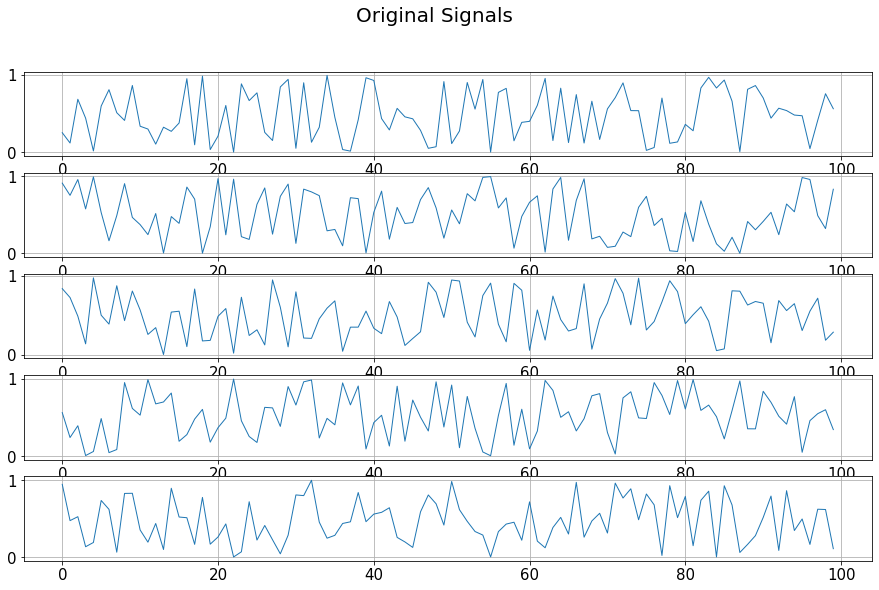

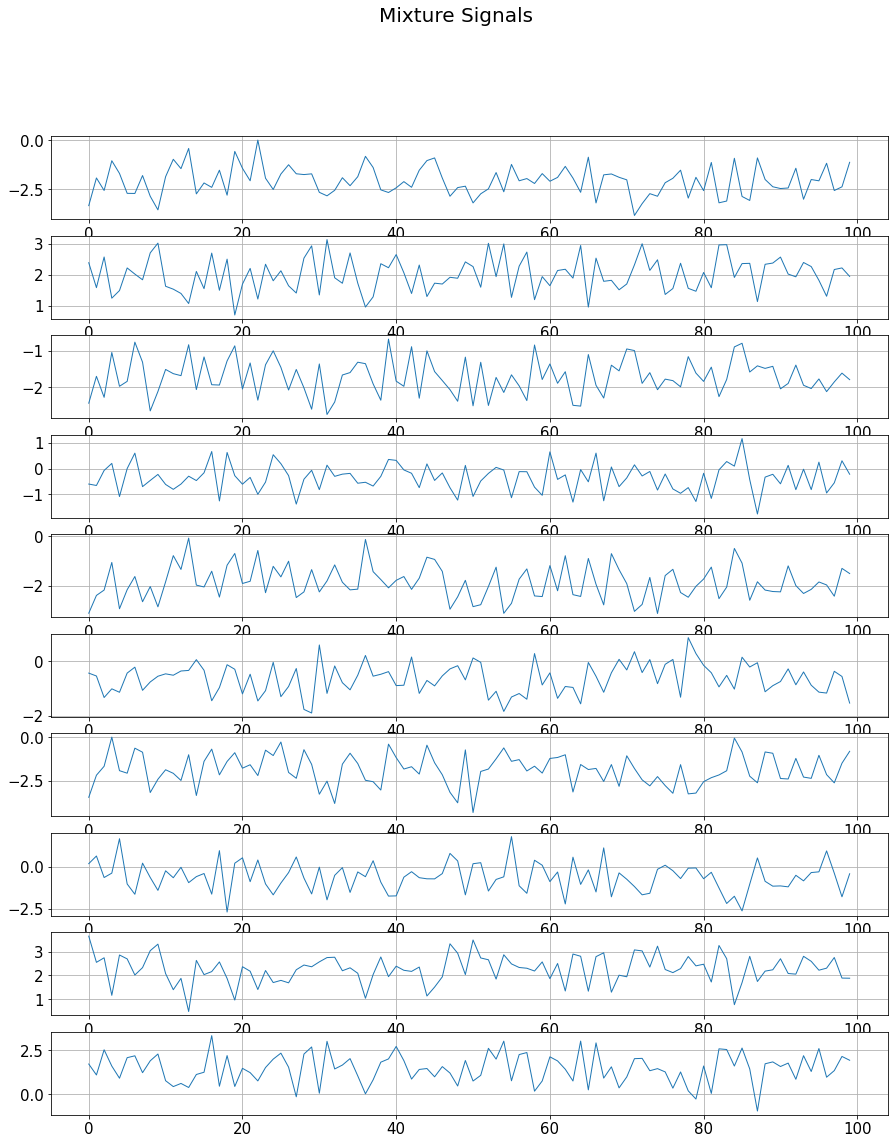

In [6]:
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X[:,0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [7]:
# # if rho > 0.4:
# #     gamma_start = 0.05
# #     gamma_stop = 5*1e-4
# # else:
# #     gamma_start = 0.2
# #     gamma_stop = 1e-3
# # OUTPUT_COMP_TOL = 1e-7
# # MAX_OUT_ITERATIONS= 3000
# # LayerGains = [4,1]
# # LayerMinimumGains = [1e-3,1e-3]
# # LayerMaximumGains = [1e6,20]
# # WScalings = [0.0033,0.0033]
# # GamScalings = [1,1]
# # zeta = 1*1e-3
# # beta = 0.5
# # muD = [1e-3, 1e-3]

# # # OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
# # synaptic_lr_rule = "divide_by_log_index" 
# # # OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
# # neural_loop_lr_rule = "divide_by_slow_loop_index"
# # s_dim = S.shape[0]
# # x_dim = X.shape[0]
# # h_dim = s_dim
# # samples = S.shape[1]
# # W_HX = np.eye(h_dim, x_dim)
# # W_YH = np.eye(s_dim, h_dim)

# # if rho > 0.4:
# #     gamma_start = 0.05
# #     gamma_stop = 5*1e-4
# # else:
# #     gamma_start = 0.1
# #     gamma_stop = 1e-3
# # OUTPUT_COMP_TOL = 1e-7
# # MAX_OUT_ITERATIONS= 3000
# # LayerGains = [1,1]
# # LayerMinimumGains = [1e-3,1e-3]
# # LayerMaximumGains = [1e6,20]
# # WScalings = [0.0033,0.0033]
# # GamScalings = [2,1]
# # zeta = 1*1e-5
# # beta = 0.5
# # muD = [1e-2, 1e-2]

# # s_dim = S.shape[0]
# # x_dim = X.shape[0]
# # h_dim = s_dim
# # samples = S.shape[1]
# # W_HX = np.eye(h_dim, x_dim)
# # W_YH = np.eye(s_dim, h_dim)

# gamma_start = 0.1
# gamma_stop = 1e-3
# OUTPUT_COMP_TOL = 1e-6
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [2,1]
# LayerMinimumGains = [1,1]
# LayerMaximumGains = [1e6,5]
# WScalings = [0.005,0.005]
# GamScalings = [1,1]
# zeta = 1*1e-5
# beta = 0.5
# muD = [0.5, 1e-3]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# W_HX = 2*np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)

# gamma_start = 0.1
# gamma_stop = 1e-3
# OUTPUT_COMP_TOL = 1e-6
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [0.5,0.5]
# LayerMinimumGains = [0.2,0.2]
# LayerMaximumGains = [1e6,5]
# WScalings = [0.005,0.005]
# GamScalings = [1,1]
# zeta = 5*1e-3
# beta = 0.5
# muD = [0.01, 0.01]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# D1 = np.flipud(np.sort(np.random.uniform(1,2, (5,)))).reshape(-1,1)
# W_HX = np.eye(h_dim, x_dim) * np.sqrt(D1)
# W_YH = np.eye(s_dim, h_dim)

# # OPTIONS FOR synaptic_lr_rule: "constant", "divide_by_log_index", "divide_by_index"
# synaptic_lr_rule = "constant" 
# # OPTIONS FOR neural_loop_lr_rule: "constant", "divide_by_loop_index", "divide_by_slow_loop_index"
# neural_loop_lr_rule = "divide_by_slow_loop_index"

# gamma_start = 0.05
# gamma_stop = 1e-3
# OUTPUT_COMP_TOL = 1e-6
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [1,1]
# LayerMinimumGains = [0.2,0.2]
# LayerMaximumGains = [1e6,5]
# WScalings = [0.005,0.005]
# GamScalings = [2,1]
# zeta = 5*1e-3
# beta = 0.5
# muD = [0.01, 0.001]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]
# W_HX = np.eye(h_dim, x_dim)
# W_YH = np.eye(s_dim, h_dim)


# gamma_start = 0.05
# gamma_stop = 1e-3
# OUTPUT_COMP_TOL = 1e-6
# MAX_OUT_ITERATIONS= 3000
# LayerGains = [2,1]
# LayerMinimumGains = [1,1]
# LayerMaximumGains = [1e6,5]
# WScalings = [0.005,0.005]
# GamScalings = [1,1]
# zeta = 1*1e-3
# beta = 0.5
# muD = [.01, 1e-3]

# s_dim = S.shape[0]
# x_dim = X.shape[0]
# h_dim = s_dim
# samples = S.shape[1]

# D1 = np.flipud(np.sort(np.random.uniform(1,2, (5,)))).reshape(-1,1)
# W_HX = np.eye(h_dim, x_dim) * np.sqrt(D1)
# W_YH = np.eye(s_dim, h_dim)

gamma_start = 0.1
gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-6
MAX_OUT_ITERATIONS= 3000
LayerGains = [0.5,0.5]
LayerMinimumGains = [0.2,0.2]
LayerMaximumGains = [1e6,5]
WScalings = [0.005,0.005]
GamScalings = [2,1]
zeta = 5*1e-3
beta = 0.5
muD = [0.01, 0.01]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

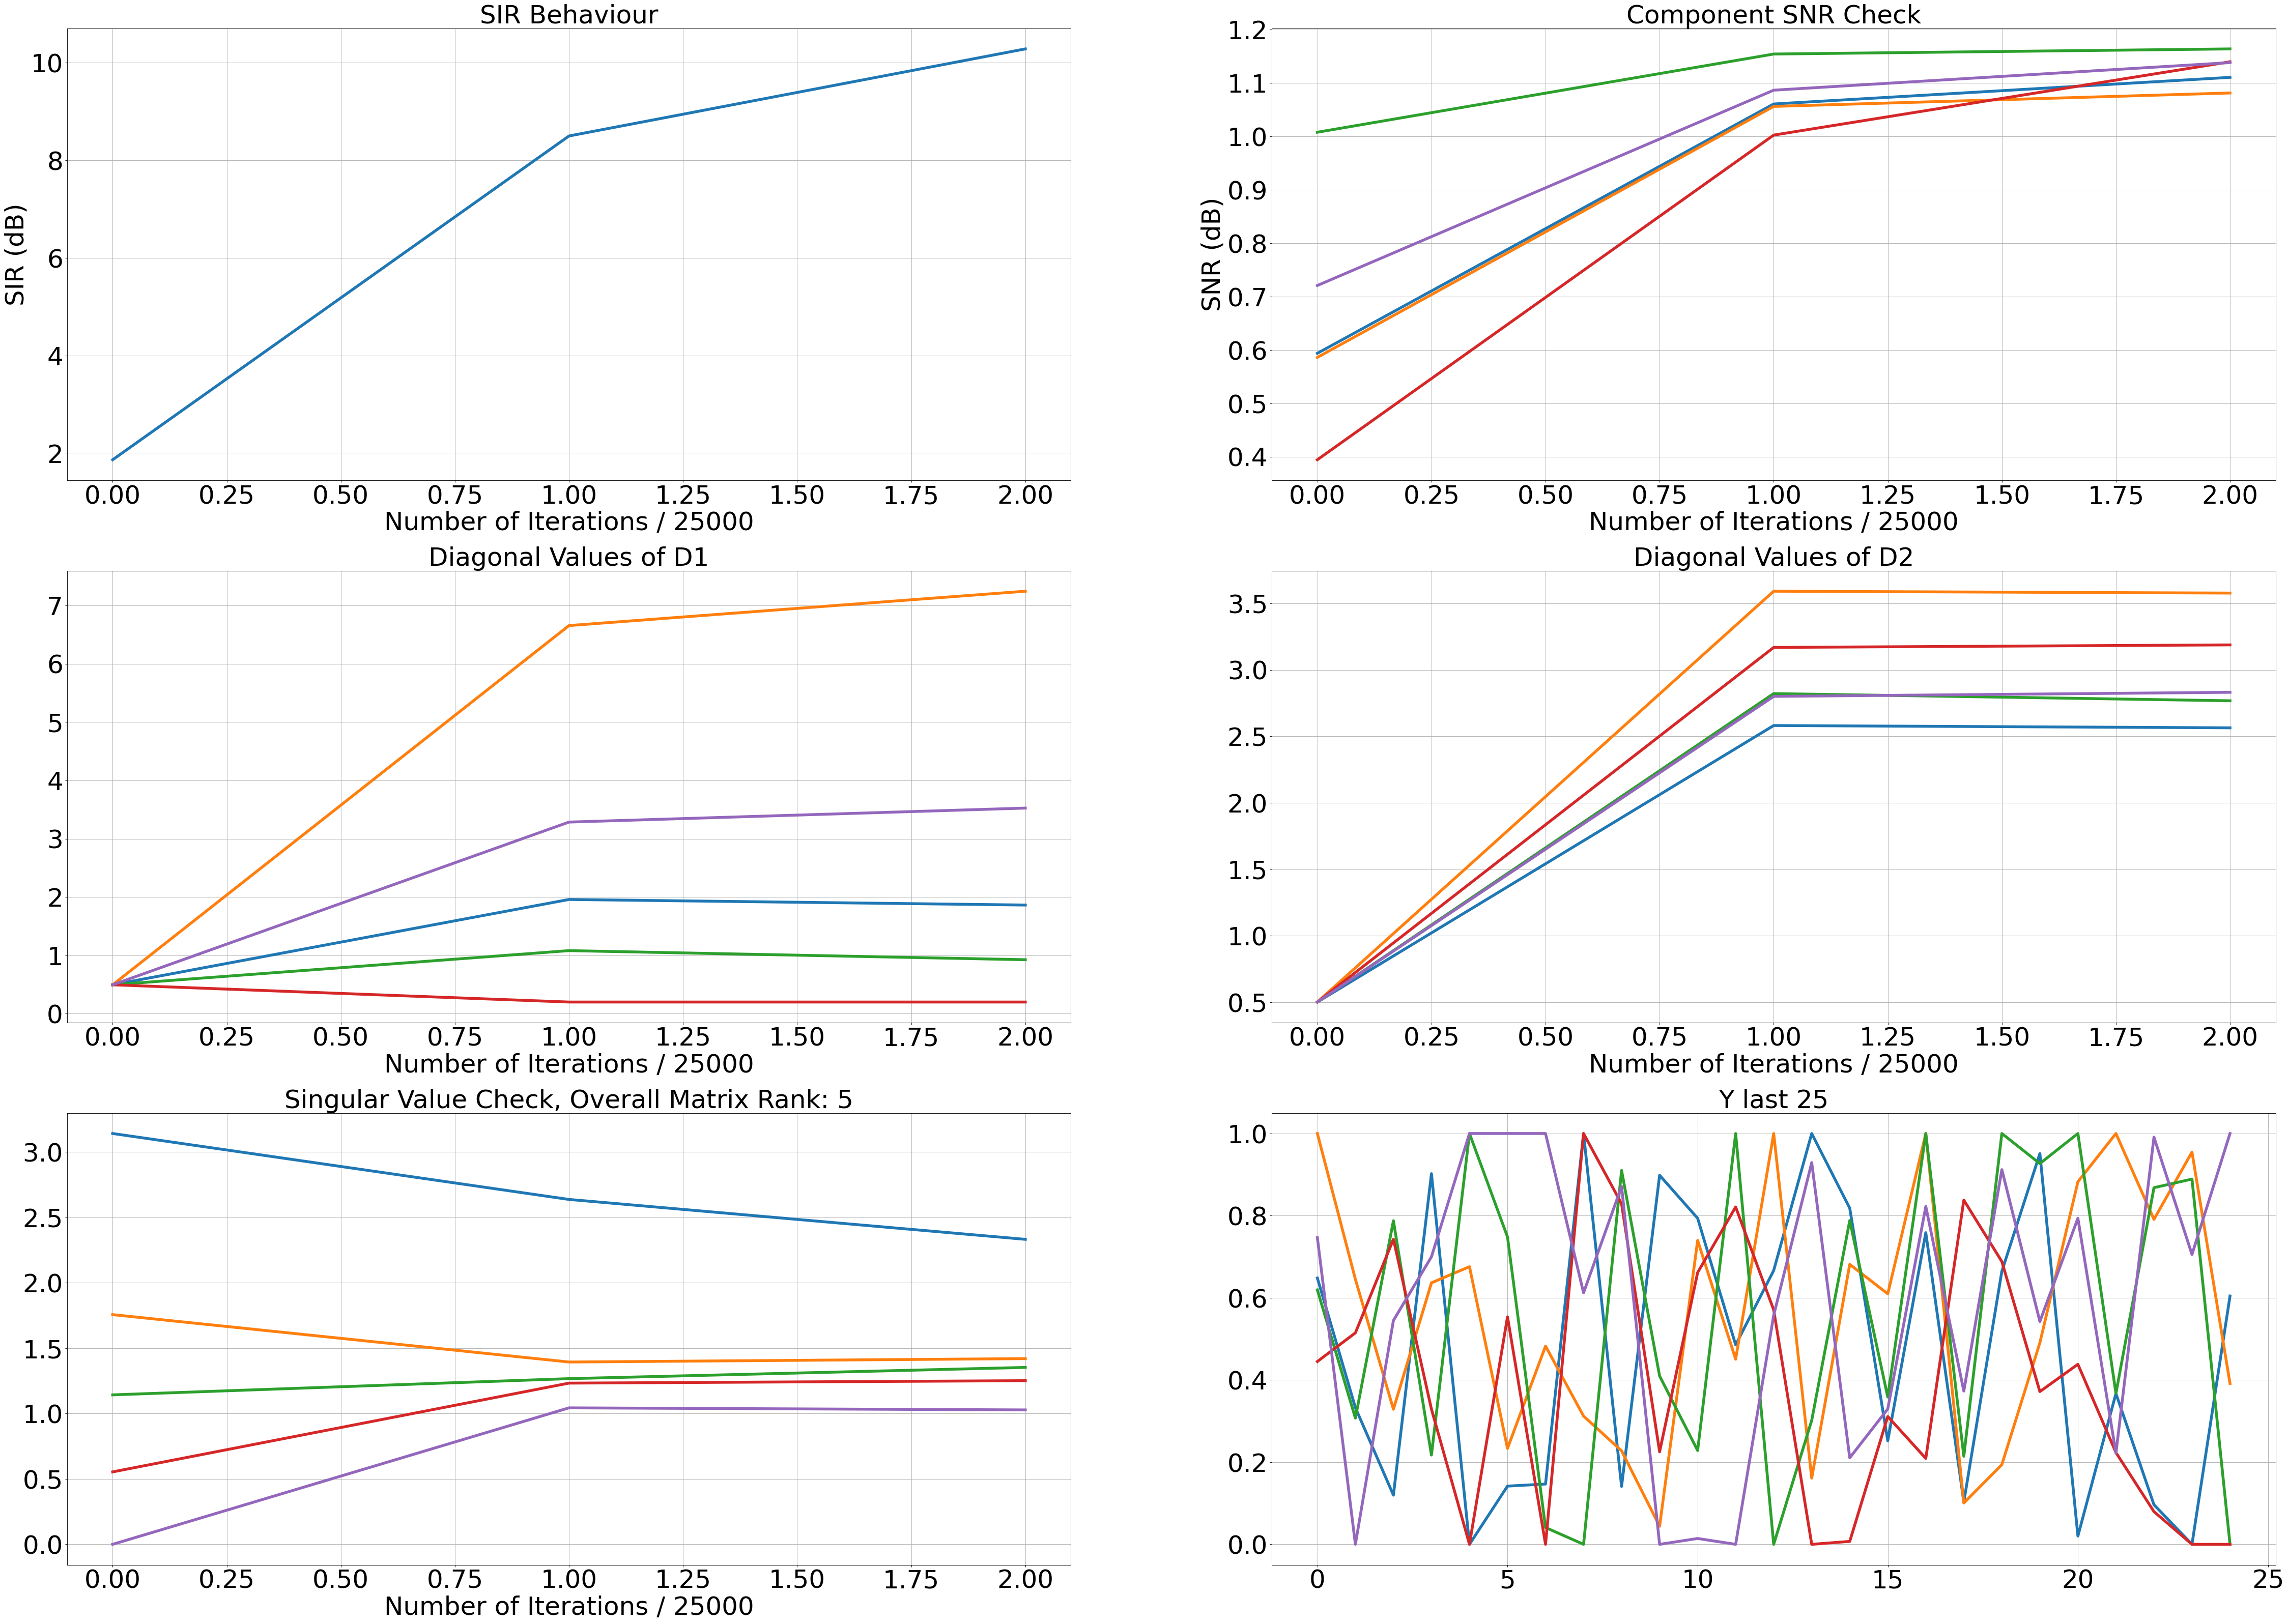

 11%|█         | 53950/500000 [02:56<15:17, 486.40it/s]  

In [ ]:
# debug_iteration_point = 25000
# modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
#                          gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
#                          muD = muD,WScalings = WScalings, GamScalings = GamScalings,
#                          W_HX = W_HX, W_YH = W_YH,
#                          D1 = D1,
#                          DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
#                          LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
#                          set_ground_truth = True, S = S, A = A)


# modelWSM.fit_batch_nnantisparse( X, n_epochs = 1, 
#                                  neural_dynamic_iterations = 750,
#                                  neural_lr_start = 1.5,
#                                  neural_lr_stop = 0.01,
# #                                  synaptic_lr_rule = synaptic_lr_rule,
# #                                  neural_loop_lr_rule = neural_loop_lr_rule,
#                                  debug_iteration_point = debug_iteration_point,
#                                  hidden_layer_gain = 1, plot_in_jupyter = True,
#                                 )

debug_iteration_point = 25000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)


modelWSM.fit_batch_nnantisparse( X, n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = .5,
                                 neural_lr_stop = 0.1,
#                                  synaptic_lr_rule = synaptic_lr_rule,
#                                  neural_loop_lr_rule = neural_loop_lr_rule,
                                 debug_iteration_point = debug_iteration_point,
                                 hidden_layer_gain = 15, plot_in_jupyter = True,
                                )

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)